# 0. Executive Summary & Project Objectives

---

### 📖 Project Context
This project replicates a professional **HR Workforce Analytics** workflow, modeled after analytical frameworks utilized during my tenure in the public sector **(Ontario Public Service)**.

While this analysis uses a synthetic dataset, the methods used—from cleaning the data to forecasting future trends—replicate the high standards required for senior leadership reporting in government. This notebook serves as a demonstration of my ability to translate raw personnel data into strategic business intelligence.

### 🎯 Strategic Objectives
The organization is currently transitioning from a rapid growth phase to a period of stabilization. This project investigates three primary business challenges:
1. **Retention & Retirement Risk:** Addressing a "knowledge drain" caused by **32.4% of staff nearing retirement (55+)**, while simultaneously solving high turnover among employees with **less than one year** of service.
2. **Net Headcount Decline:** Diagnosing the "Inflow vs. Outflow" trends to understand why the workforce experienced a **negative net flow in 2024 and 2025**.
3. **Staffing & Conversion Optimization:** Identifying and auditing a significant **backlog of contractors** who have surpassed the 18-month eligibility threshold for permanent conversion.

### 📊 Key Findings & Strategic Value
- **The Problem:** High-risk attrition is concentrated in the first 12 months, and recent growth has stalled as exits began to outpace new hiring.
- **The Solution:** Instead of spending money on expensive external recruiting, the company has 254 proven contractors ready to be moved into permanent roles.
- **The Action**: I recommend auditing the contractor backlog to speed up permanent hiring and creating a mentorship program to pass knowledge from retiring veterans to new staff.

> **Scope Note:** This EDA focuses on available employee attributes. Operational metrics such as Vacancy Rates or Secondment History are excluded due to specific dataset limitations.

# 1. Data Ingestion & Setup

This section prepares the environment for analysis and loads the processed workforce data. By setting a fixed `Analysis Date`, the notebook ensures that all age and tenure calculations remain accurate and consistent throughout the report.

In [1]:
# 1. Load & Review Cleaned Dataset
# ================================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Settings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# Config
analysis_date = pd.Timestamp("2025-11-28")

# Load
file_path = "/kaggle/input/hr-workforce-analytics-project/cleaned_employee_data.csv"
df = pd.read_csv(file_path, parse_dates=["StartDate", "ExitDate", "DOB"])

# Foundational Field - used in almost every section
df["TenureYears"] = df["TenureDays"] / 365.25

print(f"✅ Dataset Loaded: {df.shape[0]} rows")
print(f"📅 Analysis Date: {analysis_date.date()}")

df.head()

✅ Dataset Loaded: 2279 rows
📅 Analysis Date: 2025-11-28


,EmpID,FirstName,LastName,FullName,ADEmail,StartDate,ExitDate,EmployeeStatus,IsActive,AttritionFlag,...,DepartmentType,Division,EmployeeType,PayZone,TerminationType,DOB,GenderCode,RaceDesc,LocationCode,TenureYears
0,3427,Uriah,Bridges,Uriah_Bridges,uriah.bridges@bilearner.com,2022-01-12,NaT,Active,True,0,...,Production,Finance & Accounting,Contract,Zone C,Unk,1969-10-07,Female,White,34904,3.876797
1,3428,Paula,Small,Paula_Small,paula.small@bilearner.com,2025-06-05,NaT,Active,True,0,...,Production,Aerial,Contract,Zone A,Unk,1965-08-30,Male,Hispanic,6593,0.481862
2,3429,Edward,Buck,Edward_Buck,edward.buck@bilearner.com,2021-04-03,NaT,Active,True,0,...,Sales,General - Sga,Full-Time,Zone B,Unk,1991-10-06,Male,Hispanic,2330,4.654346
3,3430,Michael,Riordan,Michael_Riordan,michael.riordan@bilearner.com,2023-10-14,NaT,Active,True,0,...,Sales,Finance & Accounting,Contract,Zone A,Unk,1998-04-04,Male,Other,58782,2.124572
4,3431,Jasmine,Onque,Jasmine_Onque,jasmine.onque@bilearner.com,2021-10-21,NaT,Active,True,0,...,Sales,General - Con,Contract,Zone A,Unk,1969-08-29,Female,Other,33174,4.104038


# 2. Workforce Composition Analysis

This section establishes a baseline view of the organization. Before analyzing trends in hiring or turnover, it is important to understand the current makeup of the team: who they are, how they are employed, and how they are distributed across the business.

## 2.1 Workforce KPI Overview

In [2]:
# =================================================================
# 2.1 Workforce KPI Summary 
# =================================================================

# Create a clean subset for current employees
df_active = df[df["IsActive"] == True].copy()

# --- Snapshot 1: Historical Totals (All Data) ---
total_records = len(df)
total_leavers = df["AttritionFlag"].sum()
overall_attrition_pct = (total_leavers / total_records) * 100

kpi_historical = pd.DataFrame({
    "Metric": ["Total Employees (5-Year History)", "Current Headcount", "Total Departures", "Cumulative Attrition %"],
    "Value": [f"{total_records:,}", f"{len(df_active):,}", f"{total_leavers:,}", f"{overall_attrition_pct:.1f}%"]
})

# --- Snapshot 2: Current Team Health (Active Only) ---
avg_age = df_active["Age"].mean()
avg_tenure = df_active["TenureYears"].mean()
new_hire_pct = (df_active["TenureYears"] <= 1).mean() * 100
retirement_risk_pct = (df_active["Age"] >= 55).mean() * 100

kpi_active = pd.DataFrame({
    "Metric": ["Average Age", "Average Tenure (Years)", "New Hire Ratio (<1yr)", "Retirement Risk (Age 55+)"],
    "Value": [f"{avg_age:.1f}", f"{avg_tenure:.2f}", f"{new_hire_pct:.1f}%", f"{retirement_risk_pct:.1f}%"]
})

print("📊 Historical Context")
display(kpi_historical)
print("\n📊 Current Workforce Health")
display(kpi_active)

📊 Historical Context


,Metric,Value
0,Total Employees (5-Year History),"2,279"
1,Current Headcount,"1,113"
2,Total Departures,"1,166"
3,Cumulative Attrition %,51.2%



📊 Current Workforce Health


,Metric,Value
0,Average Age,46.8
1,Average Tenure (Years),2.45
2,New Hire Ratio (<1yr),21.7%
3,Retirement Risk (Age 55+),32.4%


### 📌 Analysis Findings

- **Historical Turnover**: The 51.2% attrition rate is a total count of everyone who left over the last 5 years. It represents a long-term total rather than a yearly spike.
- **Succession Planning**: About **32% of staff are 55 or older**, indicating a large group is approaching retirement. This will require a focus on knowledge transfer.
- **Workforce Refresh**: 21% of current employees joined in the past year, showing that the organization has been actively hiring to grow the team.

## 2.2 Workforce Structure: Status & Employment Type

This section visualizes the split between active and former employees, along with the mix of permanent and flexible roles.

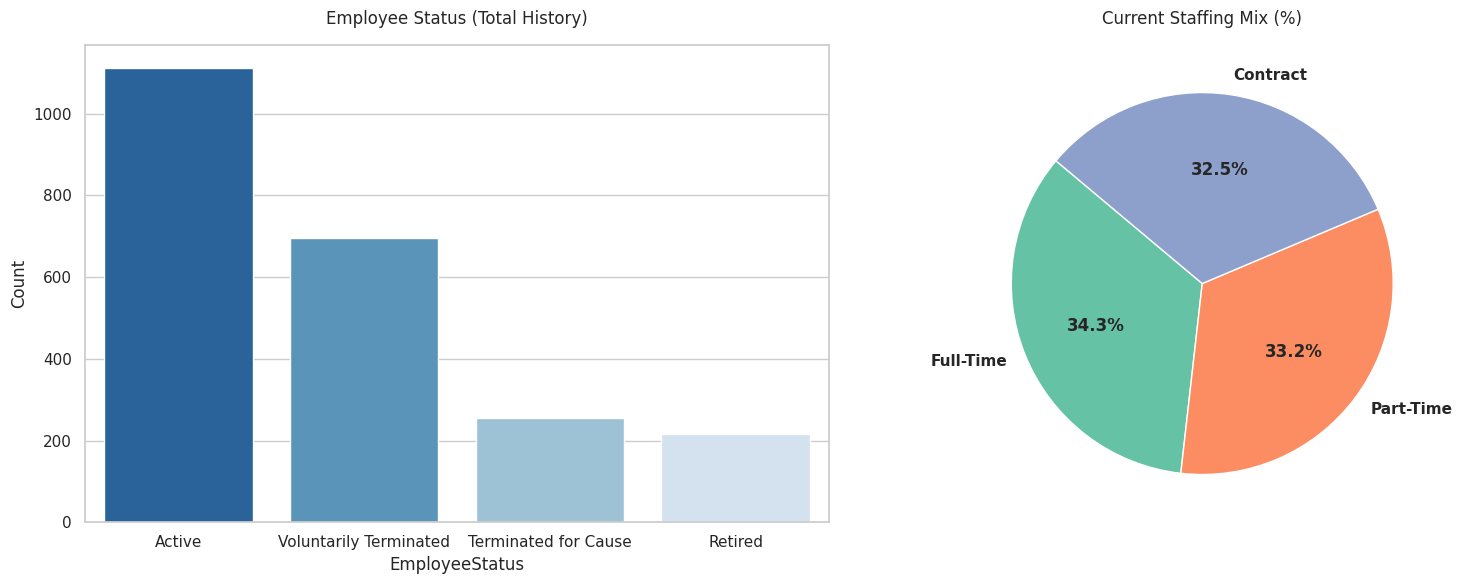

In [3]:
# =================================================================
# 2.2 Employee Status & Staffing Mix
# =================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Employee Status (All Records)
status_data = df["EmployeeStatus"].value_counts()
sns.barplot(x=status_data.index, y=status_data.values, palette="Blues_r", ax=axes[0])
axes[0].set_title("Employee Status (Total History)", pad=15)
axes[0].set_ylabel("Count")

# 2. Employment Type (Active Only)
type_data = df_active["EmployeeType"].value_counts()
axes[1].pie(type_data, 
             labels=type_data.index, 
             autopct='%1.1f%%', 
             startangle=140, 
             colors=sns.color_palette("Set2"),
             wedgeprops={'edgecolor': 'white'},
             textprops={'fontweight': 'bold'})

axes[1].set_title("Current Staffing Mix (%)", pad=15)

plt.tight_layout()
plt.show()

### 📌 Analysis Findings

- **Departure Type**: Most people who left the company did so voluntarily, which is common for a multi-year period.
- **Flexible Model**: The team is split almost equally between Full-Time, Part-Time, and Contract roles, suggesting a highly flexible staffing model.

## 2.3 Demographics: Age & Gender

This analysis focuses on the active workforce to identify organizational culture and potential retirement risks. Examining age and gender distributions helps in planning for future recruitment and ensuring a balanced workplace.

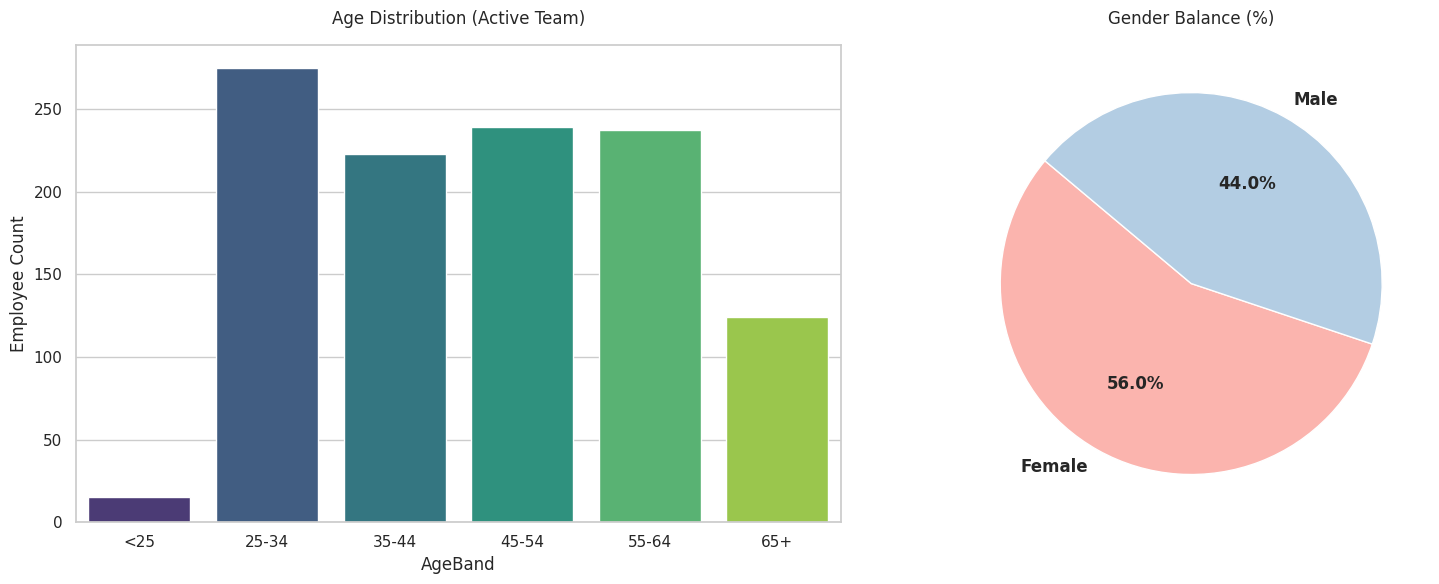

In [4]:
# =================================================================
# 2.3 Age and Gender Distribution (Active Only)
# =================================================================

# Define standard age groups
age_bins = [0, 25, 35, 45, 55, 65, 100]
age_labels = ["<25", "25-34", "35-44", "45-54", "55-64", "65+"]
df_active["AgeBand"] = pd.cut(df_active["Age"], bins=age_bins, labels=age_labels, right=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Age Groups
age_counts = df_active["AgeBand"].value_counts().sort_index()
sns.barplot(x=age_counts.index, y=age_counts.values, palette="viridis", ax=axes[0])
axes[0].set_title("Age Distribution (Active Team)", pad=15)
axes[0].set_ylabel("Employee Count")

# 2. Gender Balance
gender_counts = df_active["GenderCode"].value_counts()
axes[1].pie(gender_counts, 
             labels=gender_counts.index, 
             autopct='%1.1f%%', 
             startangle=140, 
             colors=sns.color_palette("Pastel1"),
             wedgeprops={'edgecolor': 'white'},
             textprops={'fontweight': 'bold', 'fontsize': 12})

axes[1].set_title("Gender Balance (%)", pad=15)

plt.tight_layout()
plt.show()

### 📌 Analysis Findings

- **Mature Profile**: Most employees fall into the 45–64 age range, while hiring for those under 25 is currently very limited.
- **Gender Balance**: Representation is stable and nearly equal, with a **56% Female and 44% Male** split across the organization.

## 2.4 Workforce by Department

This analysis explores the concentration of the workforce across different departments and the average experience (tenure) within those teams. Understanding where the "veteran" knowledge sits versus where the "new talent" is concentrated helps identify departments that may be more stable or those undergoing significant growth.

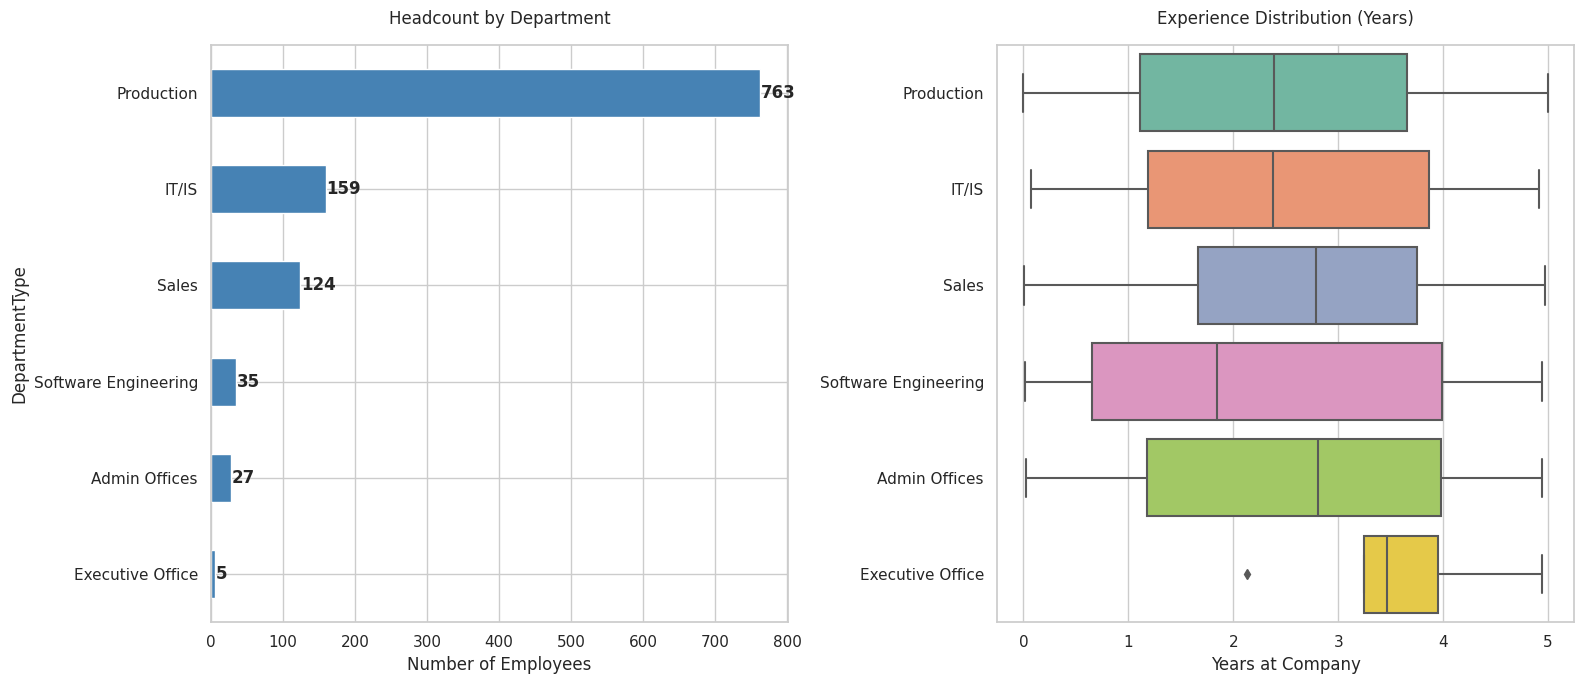

In [5]:
# =================================================================
# 2.4 Departmental Headcount & Experience (Active Only)
# =================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 1. Headcount by Department (Bar Chart)
dept_counts = df_active["DepartmentType"].value_counts().sort_values(ascending=True)
dept_counts.plot(kind='barh', color="steelblue", ax=axes[0])
axes[0].set_title("Headcount by Department", pad=15)
axes[0].set_xlabel("Number of Employees")

# Add labels for headcount
for i, v in enumerate(dept_counts):
    axes[0].text(v + 1, i, str(v), va='center', fontweight='bold')

# 2. Experience Level by Department (Boxplot)
# This shows the distribution of tenure (years) in each department
sns.boxplot(data=df_active, x="TenureYears", y="DepartmentType", 
            palette="Set2", ax=axes[1], order=dept_counts.index[::-1])
axes[1].set_title("Experience Distribution (Years)", pad=15)
axes[1].set_xlabel("Years at Company")
axes[1].set_ylabel("") # Hide ylabel to save space

plt.tight_layout()
plt.show()

### 📌 Analysis Findings
- **Operational Focus**: The **Production** department is the primary business driver, employing **70% of the active workforce**.
- **Consistent experience**: All departments have a similar balance of new and experienced staff, with the typical employee having about 2.4 years of tenure.

## 2.5 Summary of Findings

The organization is a large-scale operation supported by a stable and experienced workforce. While nearly a third of the team is approaching retirement age, consistent hiring over the past year is successfully refreshing the talent pool. This balance of veteran knowledge and new talent is spread evenly across all departments. Combined with a diverse staffing model and balanced gender representation, these patterns provide a stable foundation for the deeper analysis of hiring and turnover trends in the following sections.

# 3. Hiring & Onboarding Analysis

This section analyzes recruitment activity to understand how the organization has grown over time. By looking at hiring dates, the analysis identifies seasonal patterns and determines which departments are driving the most growth.

## 3.1 Monthly Hiring Trends (Last 12 Months)

This view tracks hiring activity over the past year to identify recent recruitment momentum and any specific peaks in monthly staffing.

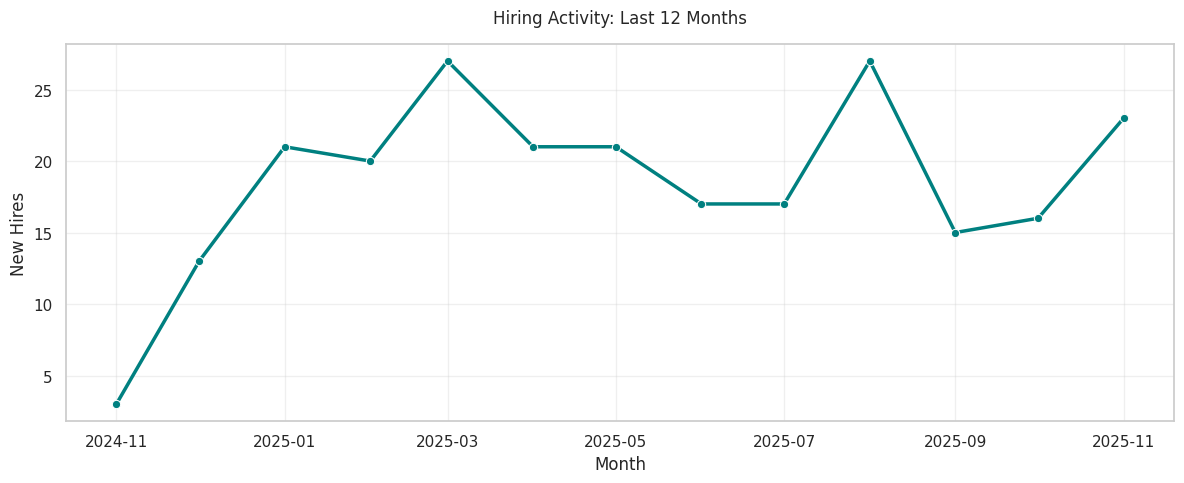

In [7]:
# =================================================================
# 3.1 Monthly Hiring Trends (Last 12 Months)
# =================================================================

# Define the 12-month window
one_year_ago = analysis_date - pd.DateOffset(years=1)

# Filter for active employees hired in the last year
recent_hires = df_active[df_active["StartDate"] >= one_year_ago].copy()

# Group by month
recent_hires["StartMonth"] = recent_hires["StartDate"].dt.to_period("M").dt.to_timestamp()
monthly_trend = recent_hires.groupby("StartMonth").size()

# Plot
plt.figure(figsize=(12, 5))
sns.lineplot(x=monthly_trend.index, y=monthly_trend.values, marker="o", color="teal", linewidth=2.5)
plt.title("Hiring Activity: Last 12 Months", pad=15)
plt.xlabel("Month")
plt.ylabel("New Hires")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 📌 Analysis Findings
- **Staffing Peaks**: Hiring activity shows clear spikes in **March and August**, suggesting specific periods where recruitment needs are highest.
- **Consistent Inflow**: Aside from these peaks, hiring remains steady throughout the year, indicating a continuous need for new talent.

## 3.2 Department Hiring Trends (Last 12 Months)

Breaking down hiring by department shows which areas of the business are growing the fastest or require the most frequent backfilling.

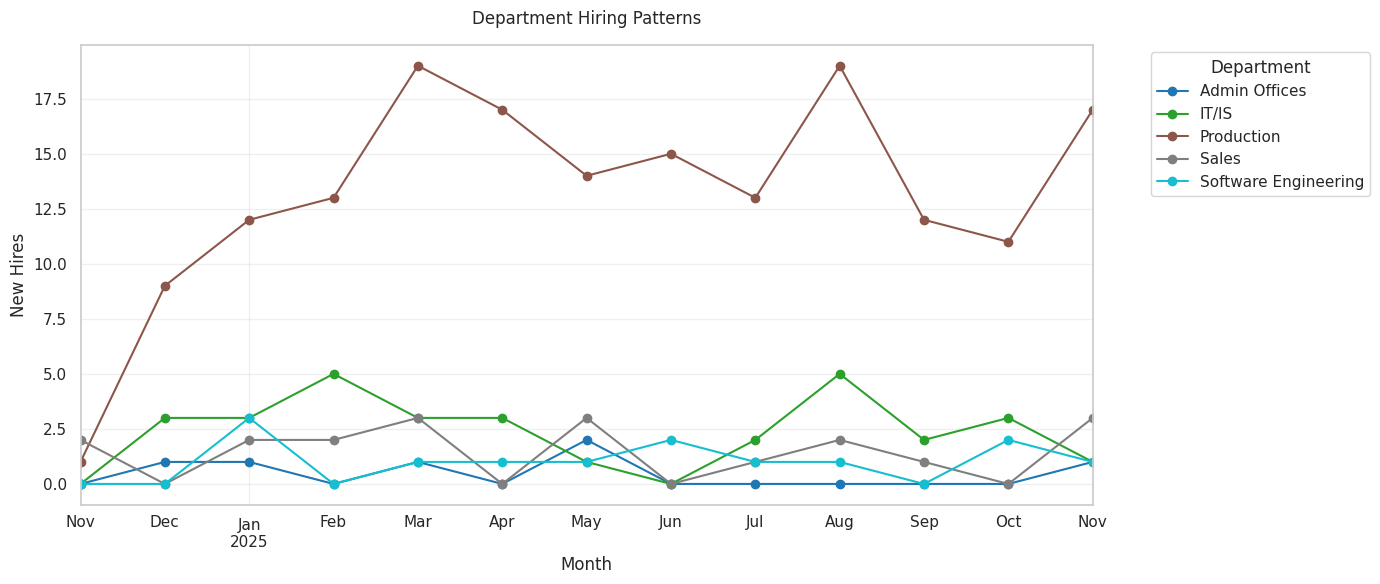

In [8]:
# =================================================================
# 3.2 Hiring by Department (Last 12 Months)
# =================================================================

# Filter and aggregate by month and department
dept_trend = recent_hires.groupby(["StartMonth", "DepartmentType"]).size().unstack(fill_value=0)

# Plot
dept_trend.plot(kind='line', marker='o', figsize=(14, 6), colormap="tab10")
plt.title("Department Hiring Patterns", pad=15)
plt.xlabel("Month")
plt.ylabel("New Hires")
plt.legend(title="Department", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 📌 Analysis Findings
- **Main Driver**: **Production** is responsible for almost all of the big hiring spikes. This is the main area where the workforce is expanding.
- **Specialized Teams**: Departments like IT/IS and Sales hire very few people at a time. This suggests these are smaller teams with fewer openings compared to the Production floor.

## 3.3 Long-Term Hiring Seasonality (5-Year Window)

Expanding the view to five years reveals whether hiring spikes are one-time events or part of a predictable yearly cycle.

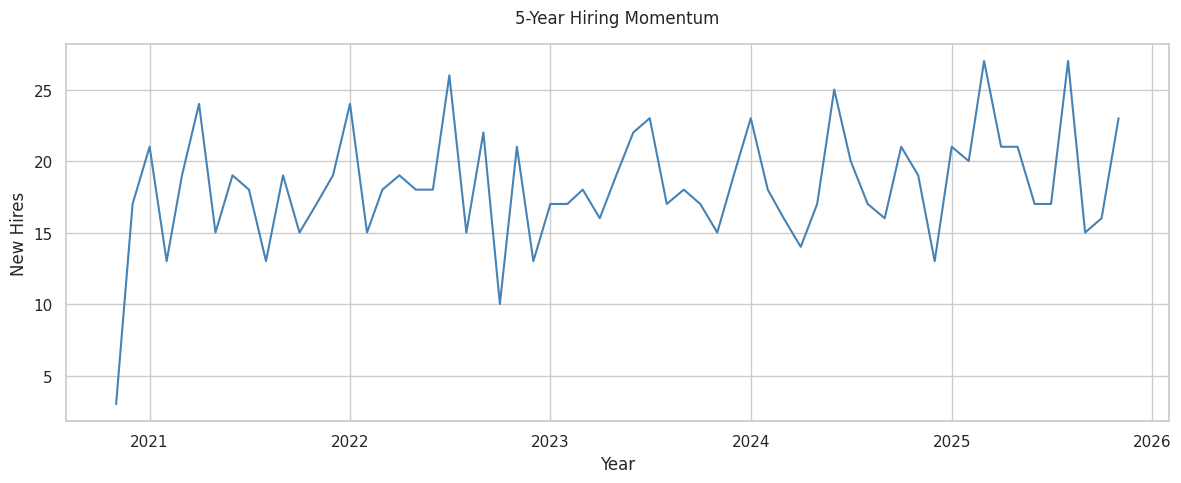

In [9]:
# =================================================================
# 3.3 Long-Term Hiring Seasonality
# =================================================================

# Group all active hires by month over 5 years
df_active["StartMonth"] = df_active["StartDate"].dt.to_period("M").dt.to_timestamp()
long_term_trend = df_active.groupby("StartMonth").size()

# Plot
plt.figure(figsize=(12, 5))
sns.lineplot(x=long_term_trend.index, y=long_term_trend.values, color="steelblue")
plt.title("5-Year Hiring Momentum", pad=15)
plt.xlabel("Year")
plt.ylabel("New Hires")
plt.tight_layout()
plt.show()

### 📌 Analysis Findings

- **Predictable Cycles**: Hiring follows a repeatable pattern, with higher volumes typically occurring at the start of each year.
- **Operational Stability**: Over five years, the total volume of monthly hiring has remained in a stable range, indicating a mature and consistent recruitment process.

## 3.4 Summary of Findings

Hiring is steady and follows a predictable seasonal rhythm, with the largest volume of activity occurring in the Production department. Recruitment typically peaks twice a year, though the organization maintains a consistent inflow of talent year-round. Over the long term, these stable patterns suggest a well-established recruitment process that effectively supports ongoing workforce growth.

# 4. Attrition & Exit Analysis

This section explores why and when employees leave the organization. By looking at exit dates and termination types, the analysis identifies patterns in turnover and highlights specific groups at higher risk of leaving.

## 4.1 Monthly Exit Trends

This view tracks the number of employees leaving each month. It helps determine if turnover is a steady occurrence or if there are sudden spikes in departures.

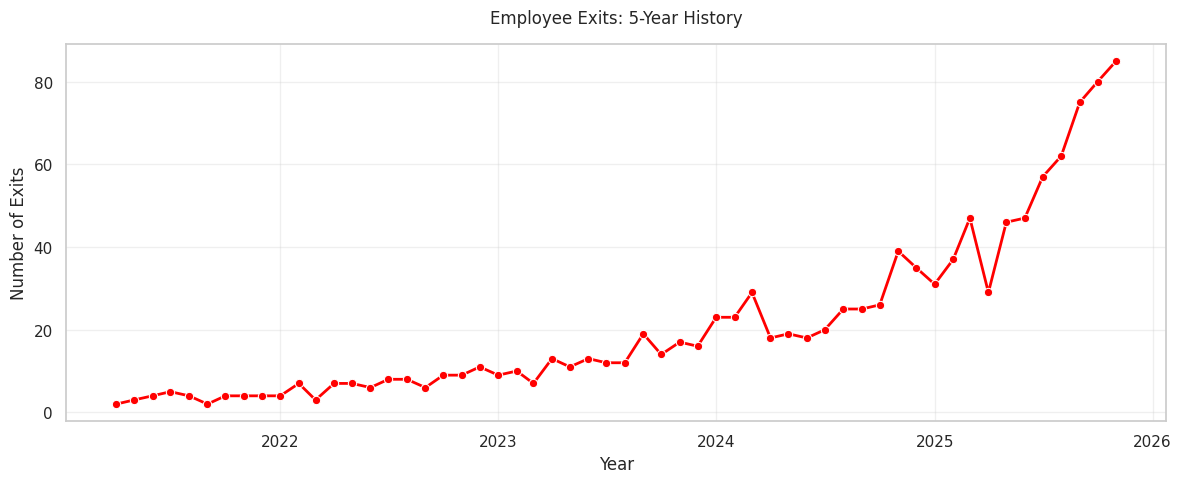

In [10]:
# =================================================================
# 4.1 Monthly Attrition Trend
# =================================================================

# Filter for all employees who have left
df_exits = df[df["AttritionFlag"] == 1].copy()

# Group by month
df_exits["ExitMonth"] = df_exits["ExitDate"].dt.to_period("M").dt.to_timestamp()
monthly_exits = df_exits.groupby("ExitMonth").size()

# Plot
plt.figure(figsize=(12, 5))
sns.lineplot(x=monthly_exits.index, y=monthly_exits.values, marker="o", color="red", linewidth=2)
plt.title("Employee Exits: 5-Year History", pad=15)
plt.xlabel("Year")
plt.ylabel("Number of Exits")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 📌 Analysis Findings

- **Growth in Volume**: As the company has grown and hired more people over the five years, the total number of people leaving has naturally increased. A larger workforce simply leads to more total exits.
- **Consistent Patterns**: Even though the number of exits is higher now, the timing and flow of these departures look normal and predictable. It follows a steady pattern rather than a sudden crisis.
- **Improved Reporting**: The peak in the most recent year also reflects more detailed and up-to-date record-keeping compared to the earlier years of the dataset.

## 4.2 Why Employees Leave (Termination Type)

This chart breaks down the reasons for departure. Comparing voluntary exits (people choosing to leave) versus involuntary exits (the company ending the employment) helps evaluate hiring quality and workforce stability.

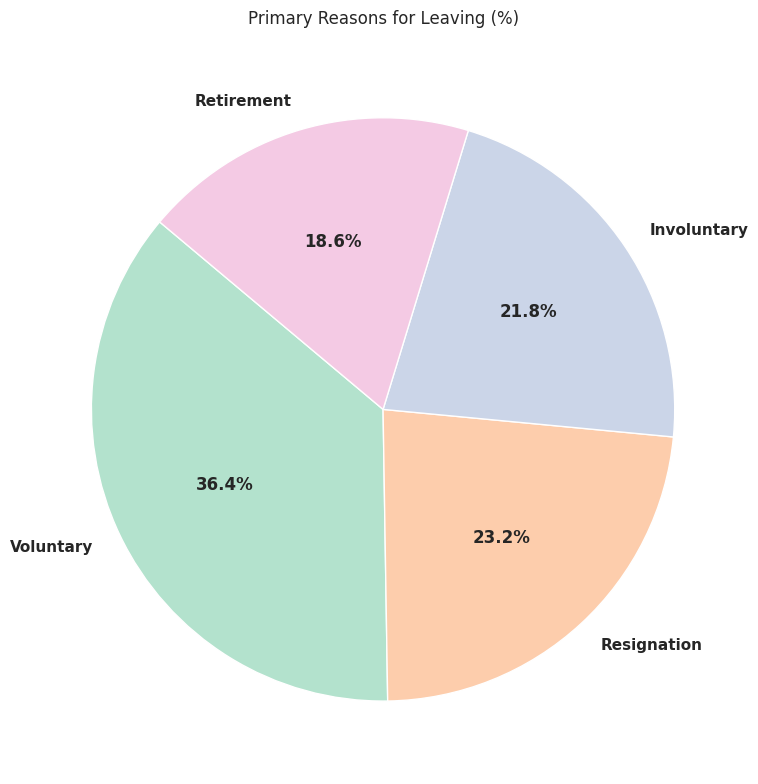

In [11]:
# =================================================================
# 4.2 Breakdown of Exit Reasons
# =================================================================

# Aggregate exit types
exit_types = df_exits["TerminationType"].value_counts()

# Plot - Using a clear, professional palette
plt.figure(figsize=(8, 8))
plt.pie(exit_types, labels=exit_types.index, autopct='%1.1f%%', startangle=140, 
        colors=sns.color_palette("Pastel2"), wedgeprops={'edgecolor': 'white'},
        textprops={'fontweight': 'bold'})
plt.title("Primary Reasons for Leaving (%)", pad=15)
plt.tight_layout()
plt.show()

### 📌 Analysis Findings

- **Personal Choice**: Most departures are **Voluntary** or **Resignations**. This indicates that the majority of people leaving are doing so for their own reasons, such as new opportunities or personal changes.
- **Low Forced Turnover**: **Involuntary** exits make up a small portion of the total. This suggests that the company is generally hiring the right people for the roles.
- **Retirement Impact**: A steady slice of departures comes from **Retirement**, which matches our earlier finding that many employees are in the 55+ age group.

## 4.3 Retention Risk by Tenure

This analysis identifies how long an employee stays before they are most likely to leave. This "Danger Zone" helps target retention efforts.

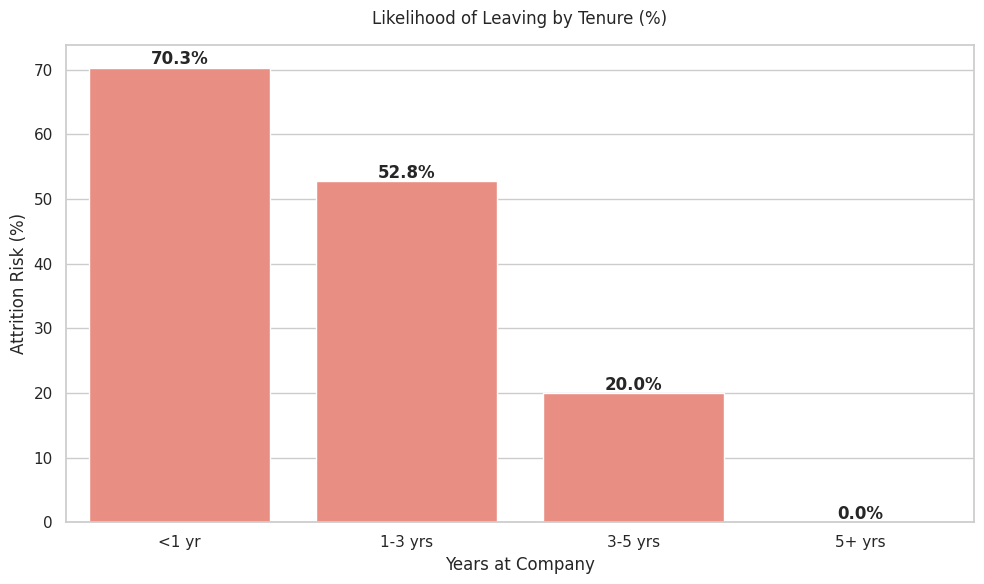

In [12]:
# =================================================================
# 4.3 Attrition Risk by Tenure Band
# =================================================================

# Define tenure bands aligned with the 5-year data window
tenure_bins = [0, 1, 3, 5, 100]
tenure_labels = ["<1 yr", "1-3 yrs", "3-5 yrs", "5+ yrs"]
df["TenureBand"] = pd.cut(df["TenureYears"], bins=tenure_bins, labels=tenure_labels, right=False)

# Update the exits slice to include the new TenureBand column
df_exits = df[df["AttritionFlag"] == 1].copy()

# Calculate the percentage of each group that has left
total_by_band = df.groupby("TenureBand").size()
exits_by_band = df_exits.groupby("TenureBand").size()
attrition_risk = (exits_by_band / total_by_band * 100).fillna(0)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=attrition_risk.index, y=attrition_risk.values, color="salmon")
plt.title("Likelihood of Leaving by Tenure (%)", pad=15)
plt.ylabel("Attrition Risk (%)")
plt.xlabel("Years at Company")

# Add percentage labels
for i, v in enumerate(attrition_risk):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### 📌 Analysis Findings
- **The First-Year Hurdle**: New employees (**under 1 year**) have the highest risk of leaving. This suggests that the onboarding period is the most important stage for keeping new talent.
- **Long-Term Loyalty**: The risk of leaving drops significantly after the 3-year mark. Once employees are settled into their roles, they become much more stable.
- **5-Year Data Limit**: You will notice that the "5+ years" category shows 0% attrition. This is because the **dataset only covers a 5-year window** (2020–2025). Therefore, we only see the behavior of people hired within this specific timeframe.

## 4.4 Department Attrition Heatmap

This map shows which departments are losing the most people and for what reasons.

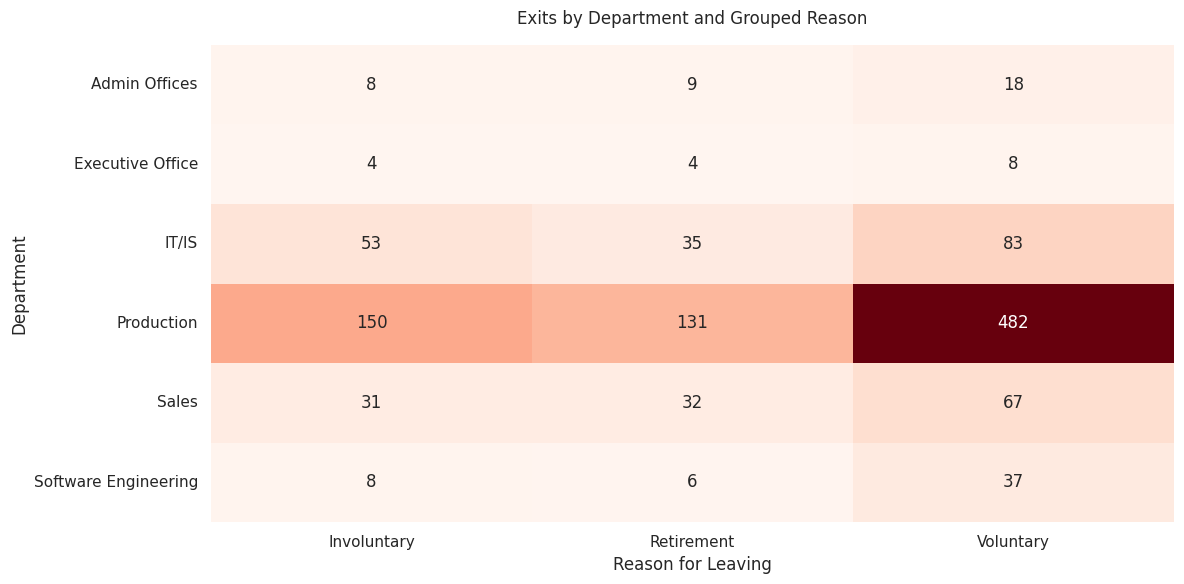

In [14]:
# =================================================================
# 4.4 Department Exit Heatmap (Grouped Reasons)
# =================================================================

# Create a simplified category column
def group_exit_reasons(reason):
    if reason in ["Voluntary", "Resignation"]:
        return "Voluntary"
    return reason

df_exits["GroupedReason"] = df_exits["TerminationType"].apply(group_exit_reasons)

# Create the heatmap data
heatmap_data = pd.crosstab(df_exits["DepartmentType"], df_exits["GroupedReason"])

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Reds", cbar=False)
plt.title("Exits by Department and Grouped Reason", pad=15)
plt.xlabel("Reason for Leaving")
plt.ylabel("Department")
plt.tight_layout()
plt.show()

### 📌 Key Insights

- **Production Churn**: Production shows the highest volume of exits across all categories, mainly because it is the largest department.
- **Common Drivers**: Voluntary departures and resignations are the leading causes of turnover across all business units.
- **Retirement Concentration**: Retirement exits are most visible in Production and IT/IS, aligning with our earlier finding regarding the aging workforce in these core areas.

## 4.5 Summary of Findings

Most turnover within the organization is voluntary, with a steady increase in departures over the five-year period as the workforce grew. The highest risk of leaving occurs within the first year of employment, while long-term employees show high stability. While the Production department has the highest total number of exits due to its size, the reasons for leaving are consistent across the board. These insights suggest a need to focus on early-career retention to stabilize the workforce.

# 5. Headcount Trend Analysis

This section tracks the total size of the workforce over time. By combining hiring data with exit data, the analysis shows the organization's net growth and identifies whether recruitment is keeping pace with departures.

## 5.1 Total Headcount Growth (5-Year View)

This chart tracks the number of active employees at the end of each month. It provides a clear picture of the company's total scale and expansion over the last five years.

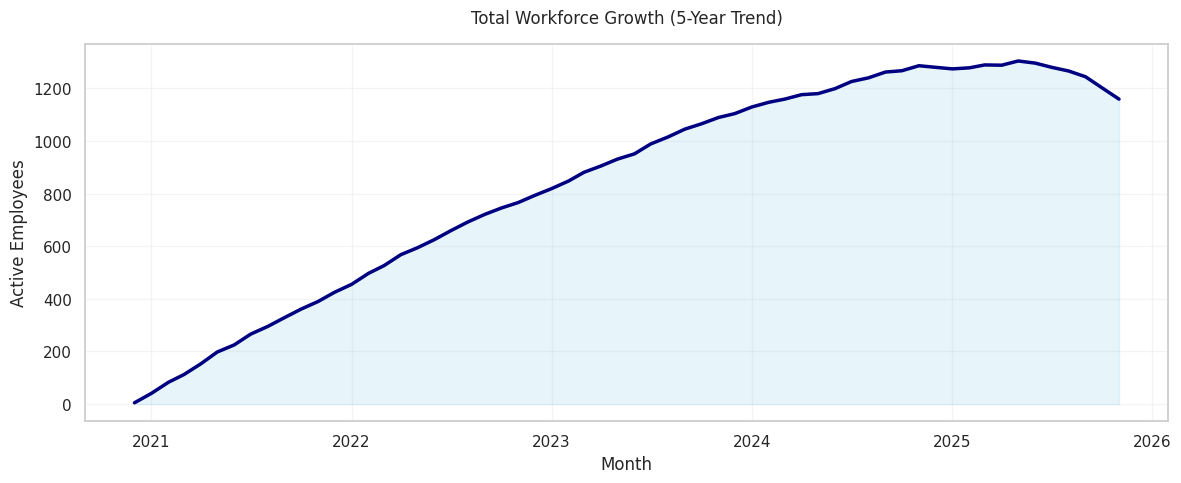

In [17]:
# =================================================================
# 5.1 Monthly Headcount Trend
# =================================================================

# Create a range of months from the first hire to the analysis date
months = pd.date_range(start=df["StartDate"].min(), end=analysis_date, freq="MS")

# Calculate how many people were active at the start of each month
def get_headcount(ref_date):
    active = (df["StartDate"] <= ref_date) & ((df["ExitDate"].isna()) | (df["ExitDate"] > ref_date))
    return active.sum()

headcount_data = pd.DataFrame({
    "Month": months,
    "Headcount": [get_headcount(m) for m in months]
})

# Plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=headcount_data, x="Month", y="Headcount", color="navy", linewidth=2.5)
plt.fill_between(headcount_data["Month"], headcount_data["Headcount"], color="skyblue", alpha=0.2)
plt.title("Total Workforce Growth (5-Year Trend)", pad=15)
plt.ylabel("Active Employees")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

### 📌 Analysis Findings
- **Steady Expansion**: The company saw consistent growth from 2020 through 2024, successfully scaling from a small team to over 1,200 employees.
- **Recent Shift**: The headcount peaked in late 2024 and has since shown a slight decline, indicating a move from a "growth phase" to a "stabilization phase."

## 5.2 Hiring vs. Exits (The Flow of Talent)

This view compares people joining (Inflow) against people leaving (Outflow). It reveals the "Net Flow" of the workforce and shows when departures began to catch up with hiring

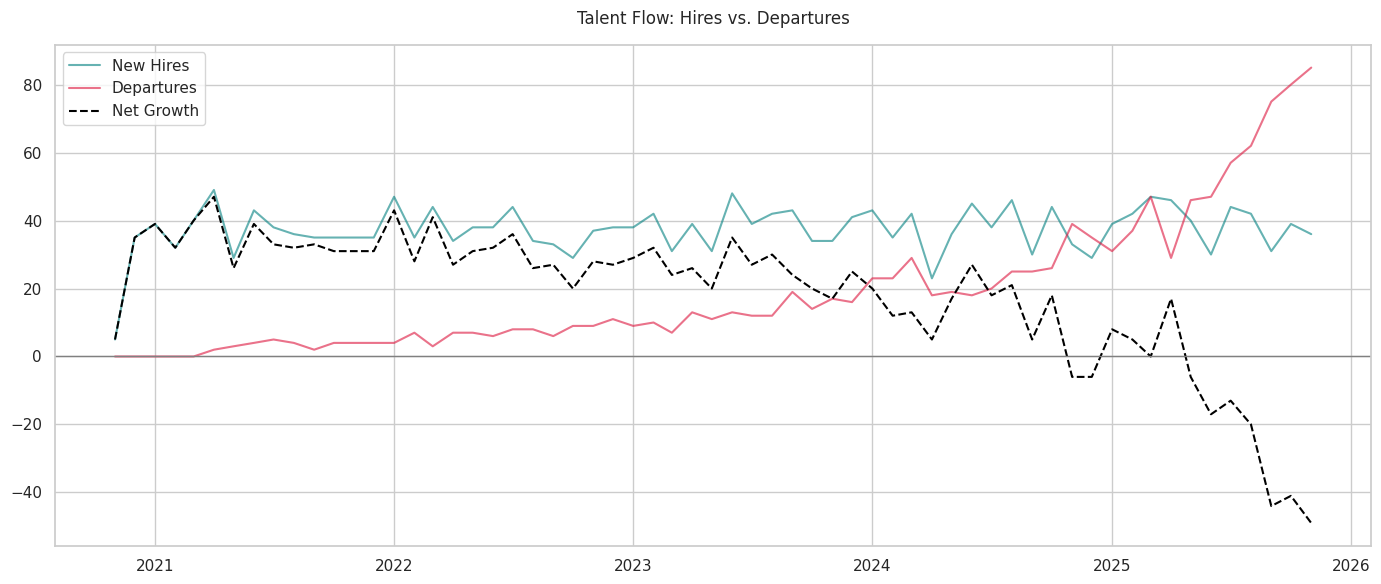

In [18]:
# =================================================================
# 5.2 Inflow vs. Outflow Comparison
# =================================================================

# 1. Prepare Monthly Data
hires_monthly = df.groupby(df["StartDate"].dt.to_period("M")).size()
exits_monthly = df[df["AttritionFlag"] == 1].groupby(df["ExitDate"].dt.to_period("M")).size()

# 2. Combine and calculate Net Flow
flow_summary = pd.DataFrame({"Hires": hires_monthly, "Exits": exits_monthly}).fillna(0)
flow_summary["NetChange"] = flow_summary["Hires"] - flow_summary["Exits"]
flow_summary.index = flow_summary.index.to_timestamp()

# 3. Plot
plt.figure(figsize=(14, 6))
plt.plot(flow_summary.index, flow_summary["Hires"], label="New Hires", color="teal", alpha=0.6)
plt.plot(flow_summary.index, flow_summary["Exits"], label="Departures", color="crimson", alpha=0.6)
plt.plot(flow_summary.index, flow_summary["NetChange"], label="Net Growth", color="black", linewidth=1.5, linestyle="--")

plt.axhline(0, color="gray", linewidth=1)
plt.title("Talent Flow: Hires vs. Departures", pad=15)
plt.legend()
plt.tight_layout()
plt.show()

### 📌 Analysis Findings
- **Positive Momentum**: For most of the 5-year period, hiring was significantly higher than exits, which drove the company’s expansion.
- **Negative Net Flow**: In 2025, departures began to exceed hiring for several months in a row. This explains the recent dip in total headcount seen in the previous chart.

### 📌 Key Insights
- Throughout most of the window, **hiring outpaced attrition**, supporting the upward headcount trend observed earlier.
- In late 2024–2025, **attrition begins exceeding hiring**, resulting in consistent negative net flow and signaling a shift toward workforce contraction.

## 5.3 Recent Net Movement (Last 12 Months)

This chart focuses on the most recent year to show exactly how much the workforce grew or shrank month-by-month.

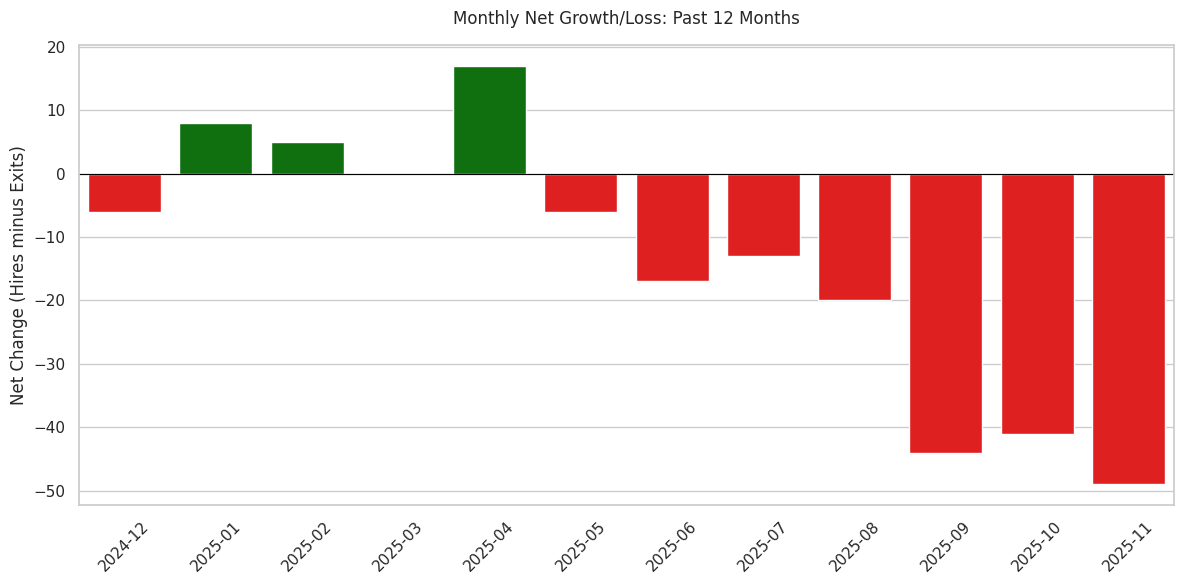

In [19]:
# =================================================================
# 5.3 Net Change (Last 12 Months)
# =================================================================

recent_flow = flow_summary[flow_summary.index >= one_year_ago].copy()

plt.figure(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in recent_flow["NetChange"]]
sns.barplot(x=recent_flow.index.strftime('%Y-%m'), y=recent_flow["NetChange"], palette=colors)

plt.title("Monthly Net Growth/Loss: Past 12 Months", pad=15)
plt.ylabel("Net Change (Hires minus Exits)")
plt.xticks(rotation=45)
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

## 📌 Analysis Findings
- **Workforce Contraction**: Over the last year, the company experienced more "red" months (losses) than "green" months (gains).
- **Critical Period**: The largest losses occurred in mid-to-late 2025, confirming that current attrition is outpacing recruitment efforts.

## 5.4 Summary of Findings

Over five years, the organization has transformed from a small team into a large-scale operation. While growth was steady for the first four years, the most recent 12 months show a clear shift: people are now leaving faster than they are being hired. This change suggests that the company is currently focusing on stabilizing its size or navigating a period of higher turnover.

# 6.Conversion Analysis

This section evaluates the **"Conversion Pipeline"**—identifying contract employees who have reached the company’s 18-month tenure requirement for full-time employment. Transitioning these proven workers is a data-driven way to stabilize headcount, reward performance, and reduce recruitment costs.

## 6.1 Current Eligibility Status

The organization's policy identifies contractors with at least **18 months** of service as eligible for permanent conversion. Identifying these individuals allows managers to initiate formal performance evaluations or internal competitions to finalize their permanent status.

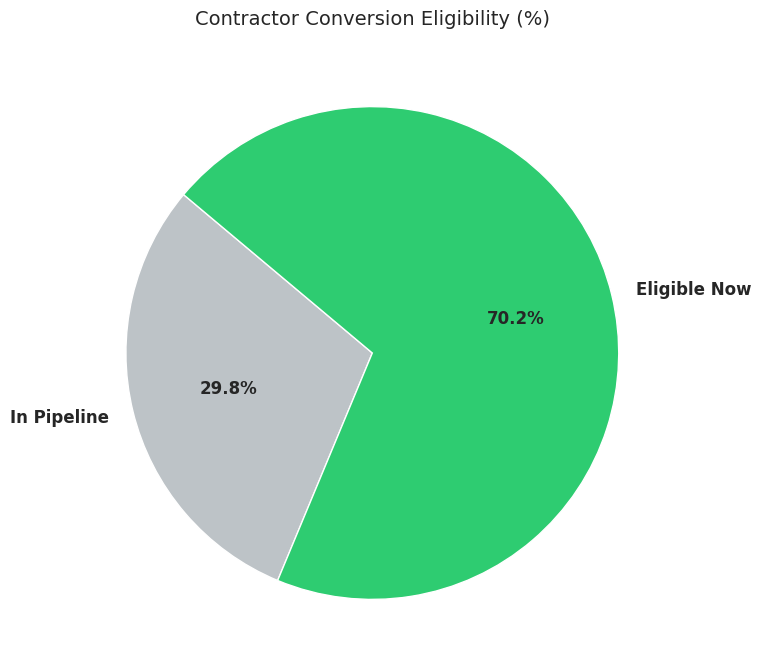

Total Active Contractors: 362
Currently Eligible for Permanent Status: 254
Still in Pipeline (Under 18 Months): 108


In [12]:
# =================================================================
# 6.1 Current Conversion Eligibility
# =================================================================

# 1. Define Policy Parameters
CONVERSION_THRESHOLD_MONTHS = 18
# analysis_date is already defined as 2025-11-28

# 2. Identify Active Contractors and their "Eligibility Date"
df_active = df[df["IsActive"] == True].copy()
df_active["EligibilityDate"] = df_active["StartDate"] + pd.DateOffset(months=CONVERSION_THRESHOLD_MONTHS)

# 3. Flag those who have already passed the 18-month mark
# We filter specifically for Contract employees
contractors = df_active[df_active["EmployeeType"] == "Contract"].copy()
contractors["IsEligibleNow"] = contractors["EligibilityDate"] <= analysis_date

# 4. Visualization: Eligible vs. In-Progress
# We sort_index to ensure False (Pipeline) is 0 and True (Eligible) is 1 for consistent labeling
eligibility_counts = contractors["IsEligibleNow"].value_counts().sort_index()

plt.figure(figsize=(8, 8))
plt.pie(eligibility_counts, 
        labels=["In Pipeline", "Eligible Now"], 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=["#bdc3c7", "#2ecc71"], 
        wedgeprops={'edgecolor': 'white'},
        textprops={'fontweight': 'bold', 'fontsize': 12})

plt.title("Contractor Conversion Eligibility (%)", pad=15, fontsize=14)
plt.show()

print(f"Total Active Contractors: {len(contractors)}")
print(f"Currently Eligible for Permanent Status: {eligibility_counts.get(True, 0)}")
print(f"Still in Pipeline (Under 18 Months): {eligibility_counts.get(False, 0)}")

### 📌 Analysis Findings
- **Significant Conversion Backlog**: **70.2% (254 employees)** of the contract workforce has already exceeded the 18-month threshold. This indicates a large volume of "proven" workers who are currently eligible for permanent status. Managers should prioritize these 254 individuals for immediate performance review or competition cycles.

## 6.2 The 6-Month Conversion Forecast

This forecast identifies when current contractors will hit their 18-month milestone. To facilitate planning for the next budget and performance cycle, this chart forecasts eligibility starting from the first full month following the analysis date (December 2025).

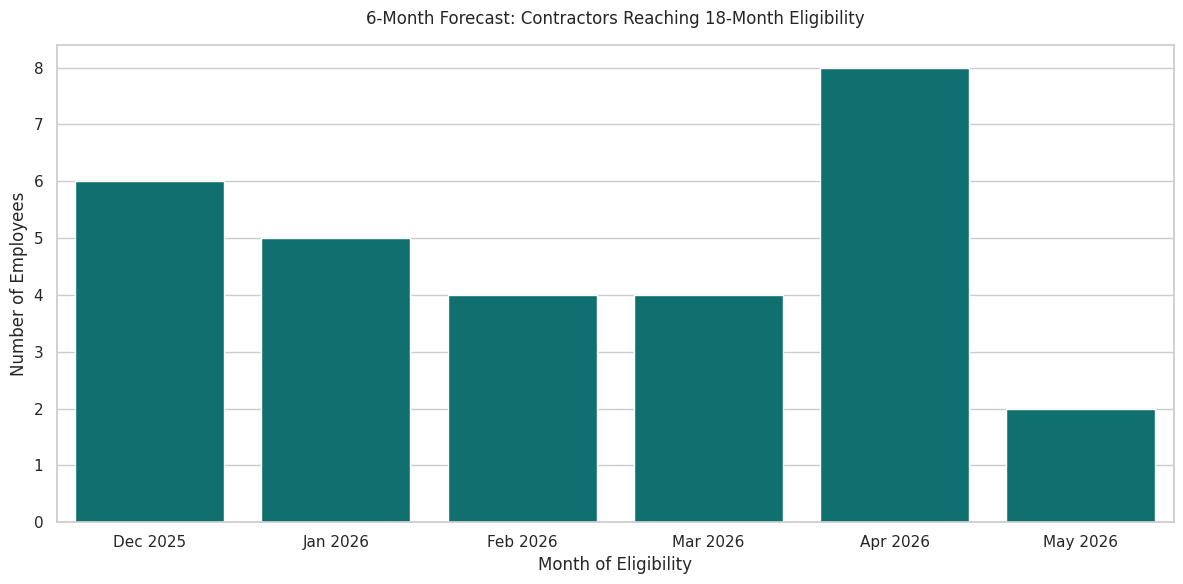

Total Forecasted Conversions (Next 6 Full Months): 29


In [11]:
# =================================================================
# 6.2 Forecast: Upcoming Eligibility
# =================================================================

# 1. Define the forecast window
# Start from the first day of the next month to exclude the current partial month (Nov)
forecast_start = (analysis_date + pd.DateOffset(months=1)).replace(day=1)
forecast_end = forecast_start + pd.DateOffset(months=6)

# 2. Filter for contractors reaching eligibility in this window
upcoming = contractors[
    (contractors["EligibilityDate"] >= forecast_start) & 
    (contractors["EligibilityDate"] < forecast_end)
].copy()

# 3. Group by month for visualization
upcoming["Month"] = upcoming["EligibilityDate"].dt.to_period("M")
forecast_trend = upcoming.groupby("Month").size()
forecast_trend.index = forecast_trend.index.to_timestamp()

# 4. Plot the 6-Month Trend
plt.figure(figsize=(12, 6))
sns.barplot(
    x=forecast_trend.index.strftime('%b %Y'), 
    y=forecast_trend.values, 
    color="teal"
)

plt.title("6-Month Forecast: Contractors Reaching 18-Month Eligibility", pad=15)
plt.ylabel("Number of Employees")
plt.xlabel("Month of Eligibility")
plt.tight_layout()
plt.show()

print(f"Total Forecasted Conversions (Next 6 Full Months): {upcoming.shape[0]}")

### 📌 Analysis Findings
- **Predictable Pipeline**: Beyond the current backlog, a steady stream of **29 additional contractors** will become eligible over the next six months. This allow managers to plan for performance reviews and budget approvals well in advance.
- **Targeted Planning**: A forecasted peak in **April 2026** provides a clear target for departmental headcount planning, ensuring the transition process is managed smoothly without overwhelming administrative resources.

## 6.3 Summary of Findings

The conversion analysis reveals a significant opportunity to reverse the recent decline in total headcount. By transitioning the 254 currently eligible contractors to permanent status, the organization can effectively "plug the leak" seen in the negative net movement charts. This strategy allows the company to stabilize its workforce using a proven pool of talent, significantly reducing the reliance on expensive external recruitment while simultaneously rewarding the loyalty of long-term contract staff.

# 7: Strategic Recommendations

This final section brings together the data story—from the stable foundation of the workforce to the recent growth challenges—and provides a clear roadmap for the organization's next steps.

## 7.1 Strategy A: Audit and Resolve the Conversion Backlog
The data highlights a backlog of **254 contractors** who have exceeded the 18-month eligibility threshold. Before initiating conversions, a targeted audit is required to resolve this operational bottleneck.

- **Categorize the Backlog**: Identify if delays are due to **Administrative Risk** (management/process lag) or **Valid Exceptions** (specific project holds or performance reviews).
- **Target Bottlenecks**: Analyze "delay days" by department and manager to pinpoint where approvals are stalling. Streamlining these workflows will stop proven talent from exiting due to career uncertainty.
- **Stabilize Headcount**: Converting the "Administrative Risk" group immediately addresses the negative net movement seen in recent months by securing staff who have already survived the high-risk first-year window.

## 7.2 Strategy B: Knowledge Transfer & Retention Bridge
With **32.4% of the workforce** nearing retirement (55+), the organization must prevent a "knowledge drain" while simultaneously addressing high turnover among new hires.

- **Mentorship Pairing**: Pair "legacy" employees (those with 5+ years of tenure) with high-risk "new talent" (those in their first year). This dual-purpose strategy ensures critical operational knowledge is transferred before veteran staff exit the workforce while providing new hires with the support needed to stay past the critical 12-month mark.

## 7.3 Strategy C: Proactive Pipeline Management
To prevent future backlogs, the organization must transition from a reactive to a proactive staffing model.

- **Forward-Looking Reviews**: Use the 6-month eligibility forecast (peaking in **April 2026**) to trigger performance reviews 30 days in advance. This proactive cycle aligns permanent job offers with budget planning and prevents a recurring "backlog" of eligible talent.

## 7.4 Final Conclusion
The organization is moving from rapid expansion to a period of stabilization. While headcount has dipped recently, the solution lies in **optimizing the existing talent pool**. By auditing the contractor backlog, resolving process bottlenecks, and bridging the experience gap through mentorship, the company can protect its operational core and build a sustainable, long-term workforce.